## Preprocessing - Adversial Debiasing  -  Compas Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import reset_default_graph
import pandas as pd
from src.data_loading import load_compas_sex, load_compas_race
from src.modeling import adversial_debiasing_train_and_predict
from src.metrics import compute_metrics, viz_metrics_2x3, compare_viz_metrics_2x3
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd


/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

## Build up the function using race

In [4]:
# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]
tf.disable_v2_behavior()

ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    # Reset TF graph - start new session (to avoid "Variable … already exists")
    reset_default_graph()
    sess = tf.Session()

    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df  = df.iloc[test_idx].reset_index(drop=True)

    # Wrap into AIF360 
    train_bld = BinaryLabelDataset(
        df=train_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        favorable_label=1.0,
        unfavorable_label=0.0,
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )
    test_bld = BinaryLabelDataset(
        df=test_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        favorable_label=1.0,
        unfavorable_label=0.0,
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )

    # Instantiate & train AdversarialDebiasing
    adv = AdversarialDebiasing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        scope_name='adv',             
        debias=True,
        sess=sess
    )
    adv.fit(train_bld)

    # Predict on test split
    pred_bld = adv.predict(test_bld)
    y_test   = test_df['label'].values
    y_pred   = pred_bld.labels.ravel()

    # Compute & store metrics
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

    sess.close()

compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])

print(compas_race_metrics_agg)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2025-05-20 08:31:36.833190: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.821393; batch adversarial loss: 0.696589
epoch 1; iter: 0; batch classifier loss: 0.886601; batch adversarial loss: 0.662019
epoch 2; iter: 0; batch classifier loss: 0.739798; batch adversarial loss: 0.647577
epoch 3; iter: 0; batch classifier loss: 0.637126; batch adversarial loss: 0.662850
epoch 4; iter: 0; batch classifier loss: 0.624222; batch adversarial loss: 0.672312
epoch 5; iter: 0; batch classifier loss: 0.649953; batch adversarial loss: 0.612596
epoch 6; iter: 0; batch classifier loss: 0.591205; batch adversarial loss: 0.614123
epoch 7; iter: 0; batch classifier loss: 0.635043; batch adversarial loss: 0.598458
epoch 8; iter: 0; batch classifier loss: 0.614809; batch adversarial loss: 0.637807
epoch 9; iter: 0; batch classifier loss: 0.631298; batch adversarial loss: 0.620905
epoch 10; iter: 0; batch classifier loss: 0.590922; batch adversarial loss: 0.638737
epoch 11; iter: 0; batch classifier loss: 0.569887; batch adversarial loss:

KeyboardInterrupt: 

## refactor function

In [ ]:
# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
    df,
    train_idx,
    test_idx,
    protected,
    privileged_value,
    unprivileged_value,
    privileged_groups,
    unprivileged_groups,
    scope_name='adv',           
    num_epochs=50,
    batch_size=128,
    adversary_loss_weight=0.1)
    
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])

print(compas_race_metrics_agg)

In [12]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

In [ ]:
baseline_race_agg

In [ ]:
compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', 'Adult Baseline - Race')

## Hyperparametersearch

In [5]:
from sklearn.model_selection import ParameterGrid
import pandas as pd

# 1) Define the hyperparameter grid
param_grid = {
    'adversary_loss_weight': [0.5, 1.0],
    'num_epochs':            [10,20, 50],
    'batch_size':            [64, 128]
}
grid = list(ParameterGrid(param_grid))

# 2) Prepare to collect results
grid_results = []

# each hyperparam setting
for params in grid:
    print(f"Testing config: {params}")
    fold_metrics = []
    
    sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            privileged_groups, unprivileged_groups,
            scope_name='adv',
            num_epochs=params['num_epochs'],
            batch_size=params['batch_size'],
            adversary_loss_weight=params['adversary_loss_weight']
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)
    
    df_fm = pd.DataFrame(fold_metrics)
    agg = df_fm.agg(['mean','std'])
    
    grid_results.append({
        **params,
        'acc_mean':   agg.loc['mean','accuracy'],
        'acc_std':    agg.loc['std', 'accuracy'],
        'f1_mean':    agg.loc['mean','f1_score'],
        'f1_std':     agg.loc['std', 'f1_score'],
        'SPD_mean':   agg.loc['mean','SPD'],
        'SPD_std':    agg.loc['std', 'SPD'],
        'DI_mean':    agg.loc['mean','DI'],
        'DI_std':     agg.loc['std', 'DI'],
        'EOD_mean':   agg.loc['mean','EOD'],
        'EOD_std':    agg.loc['std', 'EOD'],
        'AOD_mean':   agg.loc['mean','AOD'],
        'AOD_std':    agg.loc['std', 'AOD'],
    })

results_df = pd.DataFrame(grid_results)

Testing config: {'adversary_loss_weight': 0.5, 'batch_size': 64, 'num_epochs': 10}
epoch 0; iter: 0; batch classifier loss: 1.641149; batch adversarial loss: 0.629704
epoch 1; iter: 0; batch classifier loss: 0.609212; batch adversarial loss: 0.731191
epoch 2; iter: 0; batch classifier loss: 0.746303; batch adversarial loss: 0.719491
epoch 3; iter: 0; batch classifier loss: 0.652676; batch adversarial loss: 0.747363
epoch 4; iter: 0; batch classifier loss: 0.792401; batch adversarial loss: 0.702400
epoch 5; iter: 0; batch classifier loss: 0.896893; batch adversarial loss: 0.754008
epoch 6; iter: 0; batch classifier loss: 0.720319; batch adversarial loss: 0.800192
epoch 7; iter: 0; batch classifier loss: 0.707078; batch adversarial loss: 0.670767
epoch 8; iter: 0; batch classifier loss: 0.615495; batch adversarial loss: 0.689062
epoch 9; iter: 0; batch classifier loss: 0.729883; batch adversarial loss: 0.670575
epoch 0; iter: 0; batch classifier loss: 1.653388; batch adversarial loss: 0.

In [6]:
results_df

,adversary_loss_weight,batch_size,num_epochs,acc_mean,acc_std,f1_mean,f1_std,SPD_mean,SPD_std,DI_mean,DI_std,EOD_mean,EOD_std,AOD_mean,AOD_std
0,0.5,64,10,0.655745,0.016792,0.587895,0.045812,0.015181,0.238133,1.165808,0.605919,0.009986,0.255398,0.037170,0.239790
1,0.5,64,20,0.669633,0.010247,0.599469,0.030264,-0.049217,0.073621,0.876622,0.177486,-0.056889,0.083666,-0.025988,0.074328
2,0.5,64,50,0.671989,0.012076,0.589024,0.026268,-0.032000,0.044980,0.918202,0.123332,-0.027095,0.046502,-0.006971,0.042810
3,0.5,128,10,0.620707,0.048126,0.561499,0.040976,-0.032552,0.523229,1.480599,1.294098,-0.044676,0.516246,-0.017510,0.526688
4,0.5,128,20,0.658378,0.024006,0.588407,0.032196,0.000183,0.247635,1.136281,0.753036,-0.012748,0.276860,0.020988,0.250487
5,0.5,128,50,0.672211,0.012953,0.606088,0.028881,-0.040046,0.068317,0.914759,0.180504,-0.037327,0.074526,-0.014889,0.065905
6,1.0,64,10,0.653583,0.036673,0.593240,0.032648,-0.079640,0.308031,0.960033,0.442908,-0.076682,0.320761,-0.057904,0.315569
7,1.0,64,20,0.668690,0.012175,0.590078,0.032752,-0.047660,0.046936,0.873335,0.114525,-0.044904,0.040341,-0.023290,0.045368
8,1.0,64,50,0.671601,0.010963,0.595248,0.028162,-0.024743,0.035356,0.933736,0.093605,-0.021216,0.048748,0.000215,0.033173
9,1.0,128,10,0.613971,0.055932,0.550008,0.061753,0.018157,0.550291,2.330161,2.977540,0.024930,0.559868,0.035379,0.553683


In [ ]:
# thresholds fairness
di_min, di_max        = 0.8, 1.25
spd_thresh, eod_thresh, aod_thresh = 0.1, 0.1, 0.1

# filter for configs that satisfy ALL four fairness bounds
fair_configs = results_df[
    (results_df['DI_mean']  >= di_min)  & (results_df['DI_mean']  <= di_max)   &
    (results_df['SPD_mean'].abs() <= spd_thresh)                              &
    (results_df['EOD_mean'].abs() <= eod_thresh)                              &
    (results_df['AOD_mean'].abs() <= aod_thresh)
]

# 3) Sort by (1) acc_mean ↓, (2) acc_std ↑
best = fair_configs.sort_values(
    by=['acc_mean','acc_std','DI_std'],
    ascending=[False,    True,     True]
).iloc[0]
best

adversary_loss_weight      0.500000
batch_size               128.000000
num_epochs                50.000000
acc_mean                   0.672211
acc_std                    0.012953
f1_mean                    0.606088
f1_std                     0.028881
SPD_mean                  -0.040046
SPD_std                    0.068317
DI_mean                    0.914759
DI_std                     0.180504
EOD_mean                  -0.037327
EOD_std                    0.074526
AOD_mean                  -0.014889
AOD_std                    0.065905
Name: 5, dtype: float64

- refactor best_hyperparam searcher

In [10]:
from src.metrics import best_hyperparameter_advdeb
from sklearn.model_selection import StratifiedKFold

best_param = best_hyperparameter_advdeb(results_df)
loss_weight = best_param['adversary_loss_weight']
n_epochs    = int(best_param['num_epochs'])
batch_sz    = int(best_param['batch_size'])

folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)
metrics = []
for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        privileged_groups, unprivileged_groups,
        scope_name='adv',
        num_epochs=50,
        batch_size=64,
        adversary_loss_weight=0.5
    )
    m = compute_metrics(test_df, y_test, y_pred,
                        protected, privileged_value, unprivileged_value)
    metrics.append(m)
final_df = pd.DataFrame(metrics)
print(final_df.agg(['mean','std']))

epoch 0; iter: 0; batch classifier loss: 1.746304; batch adversarial loss: 0.678265
epoch 1; iter: 0; batch classifier loss: 0.865758; batch adversarial loss: 0.656912
epoch 2; iter: 0; batch classifier loss: 0.689561; batch adversarial loss: 0.633649
epoch 3; iter: 0; batch classifier loss: 0.823072; batch adversarial loss: 0.634130
epoch 4; iter: 0; batch classifier loss: 0.685312; batch adversarial loss: 0.647985
epoch 5; iter: 0; batch classifier loss: 0.639701; batch adversarial loss: 0.712285
epoch 6; iter: 0; batch classifier loss: 0.615195; batch adversarial loss: 0.609318
epoch 7; iter: 0; batch classifier loss: 0.626203; batch adversarial loss: 0.638353
epoch 8; iter: 0; batch classifier loss: 0.633976; batch adversarial loss: 0.600389
epoch 9; iter: 0; batch classifier loss: 0.629465; batch adversarial loss: 0.612369
epoch 10; iter: 0; batch classifier loss: 0.682738; batch adversarial loss: 0.615132
epoch 11; iter: 0; batch classifier loss: 0.675737; batch adversarial loss:

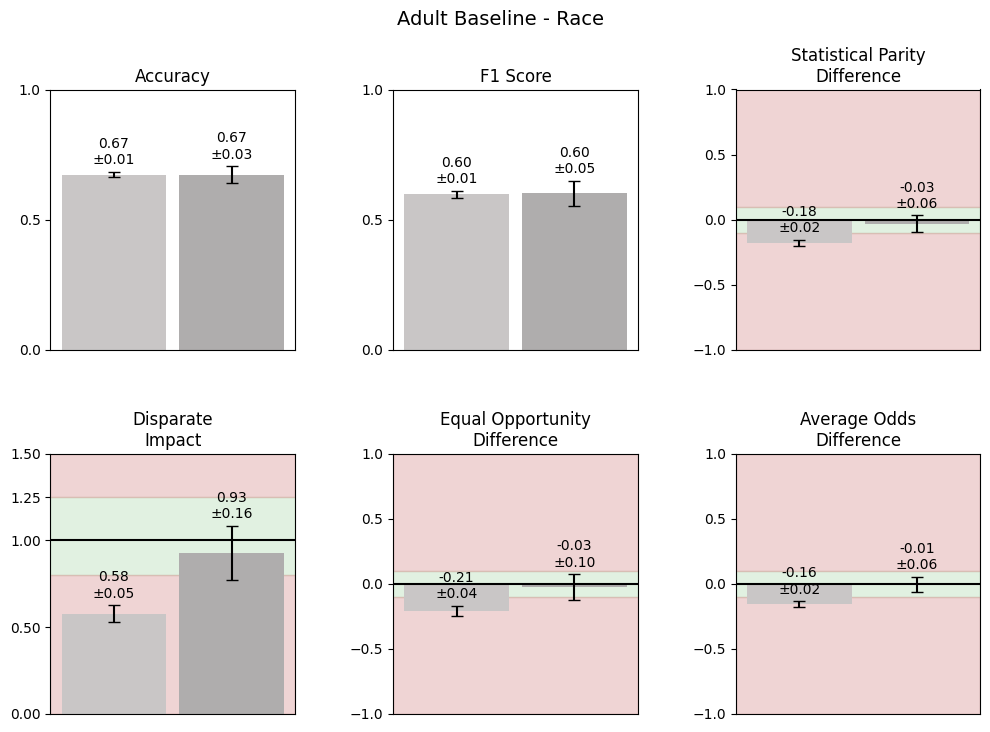

In [13]:
compare_viz_metrics_2x3(baseline_race_agg, final_df.agg(['mean','std']), 'Baseline', 'Race', 'Adult Baseline - Race')